<a href="https://colab.research.google.com/github/danielhsf/BERT/blob/main/DistilBERT_FineTuning_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook to Finetuning the DistilBERT

## Instaling the requirements

In [1]:
!pip install transformers[tf,torch,sentencepiece,vision,optuna,sklearn,onnxruntime]==4.11.3
!pip install datasets[audio]==1.16.1
!pip install matplotlib

In [2]:
!pip install torch

In [3]:
!apt install git-lfs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.3.4-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


## Importing the Dataset

In [4]:
import torch

In [5]:
from datasets import load_dataset

emotions = load_dataset("emotion")

Using custom data configuration default
Reusing dataset emotion (/root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705)


  0%|          | 0/3 [00:00<?, ?it/s]

## Config

In [6]:
model_ckpt = "distilbert-base-uncased"


## Tokenizer

In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

## Tokenizing the whole Dataset

In [8]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [9]:
# hide_output
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Loading cached processed dataset at /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705/cache-00e12102ddc73544.arrow


  0%|          | 0/1 [00:00<?, ?ba/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705/cache-9e6b023c9d77f521.arrow


## Importing the Transformer Model

In [10]:
from transformers import AutoModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Fine-Tuning Transformers

In [11]:
# hide_output
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

In [12]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

## Training the Model

In [13]:
from huggingface_hub import notebook_login

notebook_login()

ValueError: ignored

In [14]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True, 
                                  log_level="error")

In [15]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)


Cloning https://huggingface.co/danhsf/distilbert-base-uncased-finetuned-emotion into local empty directory.


Download file pytorch_model.bin:   0%|          | 3.47k/255M [00:00<?, ?B/s]

Download file runs/Mar28_02-00-03_734cc44b804c/events.out.tfevents.1648432812.734cc44b804c.73.0:  34%|###3    …

Download file runs/Mar28_02-12-15_734cc44b804c/1648433539.8911278/events.out.tfevents.1648433539.734cc44b804c.…

Download file runs/Mar28_02-00-03_734cc44b804c/1648432812.2528386/events.out.tfevents.1648432812.734cc44b804c.…

Download file training_args.bin: 100%|##########| 2.80k/2.80k [00:00<?, ?B/s]

Clean file runs/Mar28_02-00-03_734cc44b804c/events.out.tfevents.1648432812.734cc44b804c.73.0:  21%|##1       |…

Clean file runs/Mar28_02-00-03_734cc44b804c/1648432812.2528386/events.out.tfevents.1648432812.734cc44b804c.73.…

Download file runs/Mar28_02-12-15_734cc44b804c/events.out.tfevents.1648433539.734cc44b804c.921.0:  75%|#######…

Clean file runs/Mar28_02-12-15_734cc44b804c/1648433539.8911278/events.out.tfevents.1648433539.734cc44b804c.921…

Clean file training_args.bin:  36%|###5      | 1.00k/2.80k [00:00<?, ?B/s]

Clean file runs/Mar28_02-12-15_734cc44b804c/events.out.tfevents.1648433539.734cc44b804c.921.0:  21%|##1       …

Clean file pytorch_model.bin:   0%|          | 1.00k/255M [00:00<?, ?B/s]

In [16]:
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.863100,0.322135,0.904000,0.901119
2,0.254000,0.220101,0.926500,0.926558


## Ploting confusion matrix

In [19]:
import numpy as np

In [17]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [22]:
y_valid = np.array(emotions["validation"]["label"])

In [20]:
y_preds = np.argmax(preds_output.predictions, axis=1)

In [24]:
labels = emotions["train"].features["label"].names


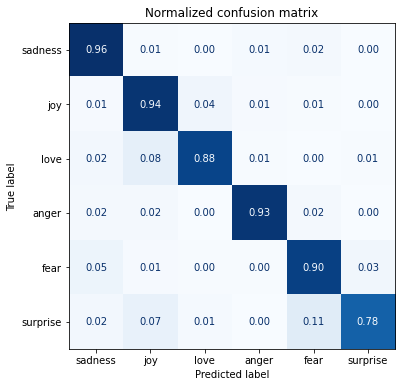

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    
plot_confusion_matrix(y_preds, y_valid, labels)

## Push to HUB

In [28]:
trainer.push_to_hub(commit_message="Training completed!")

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file runs/Mar31_02-27-31_25a82ca9a0f8/events.out.tfevents.1648693746.25a82ca9a0f8.807.0:  72%|#######1 …

To https://huggingface.co/danhsf/distilbert-base-uncased-finetuned-emotion
   fe299c4..9ed7be1  main -> main

To https://huggingface.co/danhsf/distilbert-base-uncased-finetuned-emotion
   9ed7be1..2f993e5  main -> main



'https://huggingface.co/danhsf/distilbert-base-uncased-finetuned-emotion/commit/9ed7be196809024b293ab673867750d2e11cfd55'

## Getting pipeline

In [30]:
#hide_output
from transformers import pipeline

# Change `transformersbook` to your Hub username
model_id = "danhsf/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

Downloading:   0%|          | 0.00/883 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [31]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)

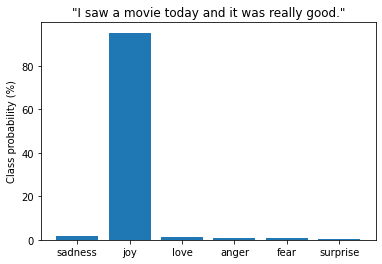

In [34]:
import pandas as pd

preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()